<a href="https://colab.research.google.com/github/saigokhale/Social-Bias-in-ER/blob/main/ER_GradCAM_Resnet50_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.datasets import ImageFolder
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as tt
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
import random
import shutil
import tarfile
import cv2
import time

%matplotlib inline

FER 2013 Dataset from Kaggle

In [ ]:
import os
link="https://www.kaggle.com/datasets/jayeshrohansingh/emotion-detection-dataset/download?datasetVersionNumber=1"
#011960f626b19ef4ab6e3f9ffe8ba027
od.download(link, force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: saigokhale
Your Kaggle Key: ··········


100%|██████████| 151M/151M [00:01<00:00, 143MB/s]


In [ ]:
DATA_DIR = '/content/emotion-detection-dataset/fer2013'

In [ ]:
class_labels=os.listdir(DATA_DIR+"/train")
sorted(class_labels)

['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

In [ ]:
pretrained_size = 224 # 48*48

train_transforms = tt.Compose([
                           tt.Resize((pretrained_size, pretrained_size)),
                           tt.RandomRotation(5),
                           tt.RandomHorizontalFlip(0.5),
                           tt.ToTensor()

                       ])

val_transforms = tt.Compose([
                           tt.Resize((pretrained_size, pretrained_size)),
                           tt.ToTensor()
                       ])

test_transforms = tt.Compose([
                           tt.Resize((pretrained_size, pretrained_size)),
                           tt.ToTensor(),
                       ])

In [ ]:
train_ds = ImageFolder(DATA_DIR+'/train', train_transforms)
valid_ds = ImageFolder(DATA_DIR+'/validation', val_transforms)
test_ds = ImageFolder(DATA_DIR+'/validation', test_transforms)

In [ ]:
print(f'Number of training examples: {len(train_ds)}')
print(f'Number of validation examples: {len(valid_ds)}')
print(f'Number of testing examples: {len(test_ds)}')

Number of training examples: 28709
Number of validation examples: 3589
Number of testing examples: 3589


In [ ]:
BATCH_SIZE = 64
train_dl = DataLoader(train_ds,
                                 shuffle = True,
                                 batch_size = BATCH_SIZE)

valid_dl = DataLoader(valid_ds,
                                 shuffle = True,
                                 batch_size = BATCH_SIZE)

test_dl = DataLoader(test_ds,
                                shuffle = True,
                                batch_size = BATCH_SIZE)

In [ ]:
def show_batch(dl, class_labels):
  for images, label in dl:
      fig = plt.figure(figsize=(12, 12))
      for i in range(images.shape[0]):
        ax = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[])
        ax.imshow(images[i].permute(1,2,0))
        ax.set_title(sorted(class_labels)[label[i]])
      break

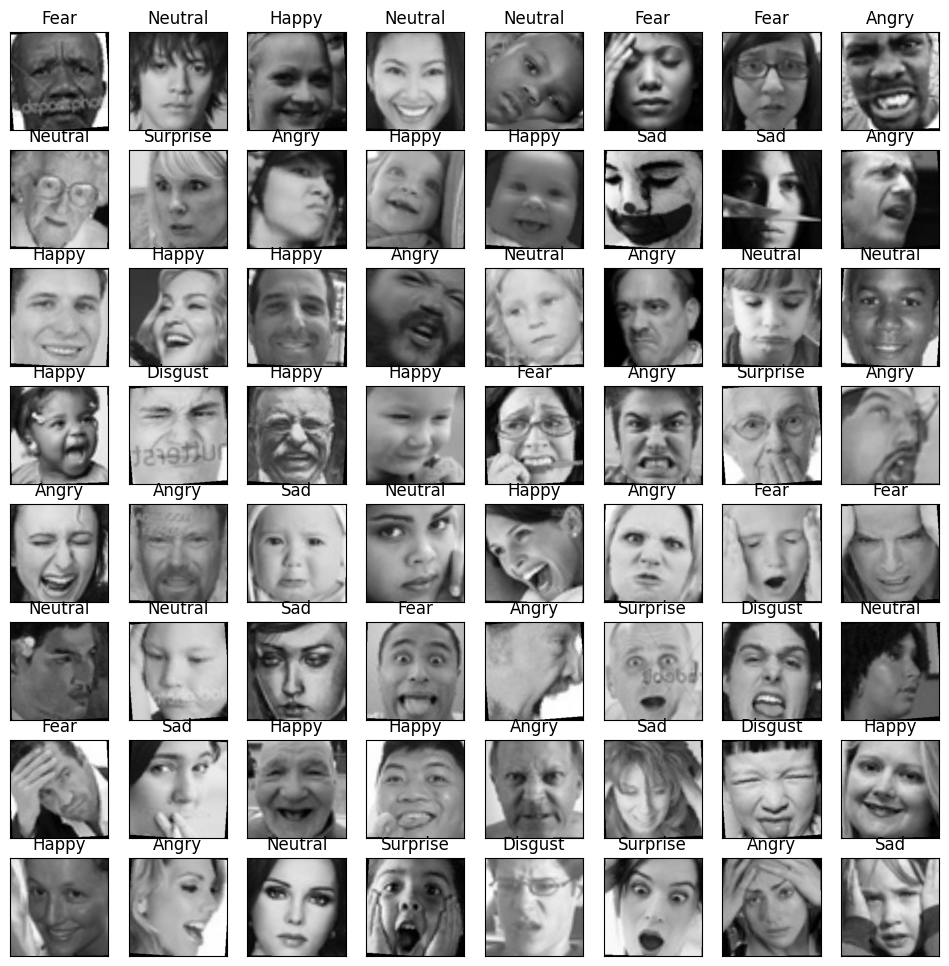

In [ ]:
show_batch(train_dl, class_labels)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cpu')

In [ ]:
train_dl2 = DeviceDataLoader(train_dl, device)
valid_dl2 = DeviceDataLoader(valid_dl, device)
test_dl2 = DeviceDataLoader(test_dl, device)

In [ ]:
import torchvision
from torchvision import models
import torchvision.models.efficientnet as e
import torchvision.models.resnet as r
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ERBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '',
            result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
from torchvision import models

class ERModel(ERBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

    def forward_hook(self,module,input,output):
        self.activation.append(output.detach().cpu().numpy())
        #print(self.activation)

    def backward_hook(self,module,grad_in,grad_out):
        self.grad.append(grad_out[0].detach().cpu().numpy())
        #print(self.grad)

    def generate_gradcam(self, image):
        self.network.eval()

        img, label=image
        # img=img
        img2=img

        img=img.to('gpu')
        img2=img2.to('gpu')

        target_layer= self.network.layer4[-1]

        # grad=[]
        # activation=[]

        self.network.layer4[-1].register_forward_hook(self.forward_hook)
        self.network.layer4[-1].register_backward_hook(self.backward_hook)

        print(len(self.grad))
        print(len(self.activation))


        self.activation = []
        self.grad = []

        # forward pass to get activations
        out=self.network(img.unsqueeze(0))

        time.sleep(1)

        loss_max=torch.argmax(out)
        loss=out[0,loss_max]

        # clear the gradients
        self.network.zero_grad()

        # backward pass to get gradients
        # loss.backward()
        # get the gradients and activations collected in the hook
        grads=self.grad[0].data.numpy().squeeze()
        fmap=self.activation[0].data.numpy().squeeze()

        if(fmap.shape!=grads.shape):
          print("!!!Activation not matching Gradients!!!")
          print(fmap.shape)
          print(grads.shape)

        tmp=grads.reshape([grads.shape[0],-1])
        # Get the mean value of the gradients of every featuremap
        weights=np.mean(tmp,axis=1)
        cam = np.zeros(grads.shape[1:])
        for i,w in enumerate(weights):
          cam += w*fmap[i,:]
        cam=(cam>0)*cam
        cam=cam/cam.max()*255

        npic=np.array(torchvision.transforms.ToPILImage()(img2).convert('RGB'))
        cam = cv2.resize(cam,(npic.shape[1],npic.shape[0]))
        heatmap=cv2.applyColorMap(np.uint8(cam),cv2.COLORMAP_JET)
        cam_img=npic*0.6+heatmap*0.4
        display(torchvision.transforms.ToPILImage()(np.uint8(cam_img[:,:,::-1])))

In [ ]:
model = ERModel(len(train_ds.classes))

In [ ]:
to_device(model, device);

In [ ]:
history = [evaluate(model, valid_dl2)]
history

In [ ]:
import random as rd
def show_gradcam(model, test_ds):
  random_idx=rd.randint(0, len(test_ds))
  trial_image=test_ds[random_idx]
  model.generate_gradcam(trial_image)
  print(sorted(class_labels)[trial_image[1]])

In [ ]:
show_gradcam(model, train_ds)

AttributeError: ignored

In [ ]:
epochs = 6
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam


In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl2, valid_dl2,
                         grad_clip=grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func)

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [0],last_lr: 0.00603, train_loss: 1.3194, val_loss: 1.7568, val_acc: 0.4077


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00994, train_loss: 1.2850, val_loss: 1.8375, val_acc: 0.3957


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00812, train_loss: 1.2295, val_loss: 1.5358, val_acc: 0.4385


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00463, train_loss: 1.1695, val_loss: 1.4741, val_acc: 0.4651


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00133, train_loss: 1.0683, val_loss: 1.3798, val_acc: 0.5287


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.00000, train_loss: 0.9362, val_loss: 1.3623, val_acc: 0.5576
CPU times: user 13min 30s, sys: 58.1 s, total: 14min 28s
Wall time: 14min 37s


In [ ]:
epochs_2 = 10
lr_2 = 0.002
opt_func_2 = torch.optim.Adam

In [ ]:
%%time
history += fit(epochs_2, lr_2, model, train_dl2, valid_dl2, opt_func=opt_func_2)

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.9938, val_loss: 1.4182, val_acc: 0.5100


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.9414, val_loss: 1.5160, val_acc: 0.5377


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.9020, val_loss: 1.4415, val_acc: 0.5355


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.8653, val_loss: 1.4767, val_acc: 0.5498


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.8220, val_loss: 1.5313, val_acc: 0.5618


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.7795, val_loss: 1.4807, val_acc: 0.5580


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.7443, val_loss: 1.5423, val_acc: 0.5473


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.6998, val_loss: 1.5208, val_acc: 0.5635


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.6542, val_loss: 1.6179, val_acc: 0.5804


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.6087, val_loss: 1.7161, val_acc: 0.5512
CPU times: user 21min 59s, sys: 1min 37s, total: 23min 37s
Wall time: 23min 51s


In [ ]:
history += fit(epochs_2, lr_2, model, train_dl2, valid_dl2, opt_func=opt_func_2)

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.5517, val_loss: 1.7548, val_acc: 0.5681


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.4987, val_loss: 1.8100, val_acc: 0.5655


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.4575, val_loss: 1.8809, val_acc: 0.5520


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.4241, val_loss: 2.1054, val_acc: 0.5594


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.3968, val_loss: 2.1890, val_acc: 0.5542


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.3588, val_loss: 2.2193, val_acc: 0.5719


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.3332, val_loss: 2.2460, val_acc: 0.5650


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.3100, val_loss: 2.3240, val_acc: 0.5761


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.2730, val_loss: 2.4448, val_acc: 0.5666


  0%|          | 0/449 [00:00<?, ?it/s]

### MODEL 2 GradCAM

In [ ]:
show_gradcam(mdoel, train_ds)